# SKIN CANCER DETECTION

## import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np

## set sizes

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCHS = 150

## Read Dataset From Disk(class)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "skin-cancer-detection-data",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
len(dataset)

Found 21774 files belonging to 6 classes.


681

In [4]:
class_names = dataset.class_names
class_names

['BCC', 'Dermatofibroma', 'Melanoma', 'Normal', 'SCC', 'unknown']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[2 2 2 3 4 3 0 4 1 5 3 0 2 5 0 2 2 0 2 2 2 2 0 2 0 0 5 3 0 3 4 2]


## Set Class to images

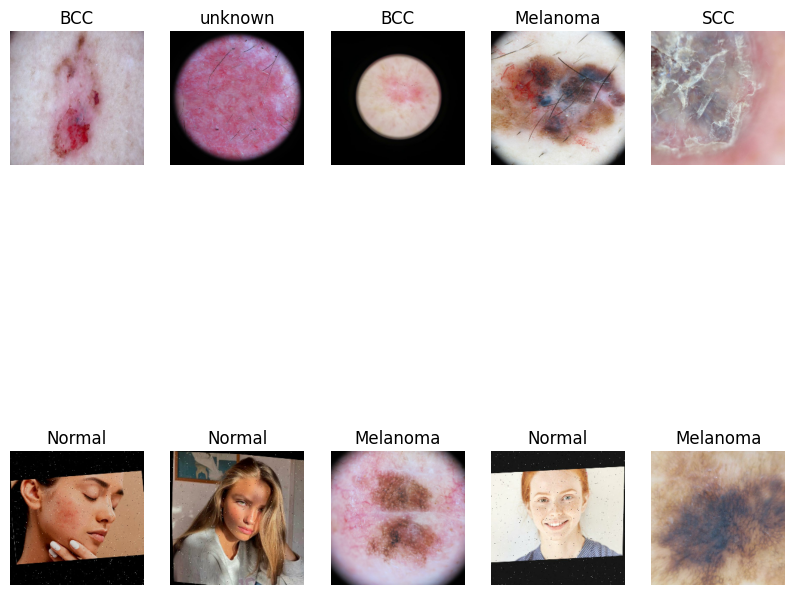

In [6]:
#plt.figure(figsize=(10, 10))
#for image_batch, label_batch in dataset.take(1):
#    for i in range(1, 11):
#        ax = plt.subplot(5, 4, i)
#        plt.imshow(image_batch[i].numpy().astype("uint8"))
#        plt.title(class_names[labels_batch[i]])
#        plt.axis("off")
import math

num_images = 10
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")

In [7]:
len(dataset)

681

### Dividing Dataset
75% ==> training
30% ==> 15% validation, 15% test

In [8]:
train_size = 0.7
val_size = 0.15
test_size = 0.15

total_batches = len(dataset)  # 660

train_ds = int(total_batches * train_size)  # 462 batches
val_ds = int(total_batches * val_size)     # 99 batches
test_ds = total_batches - train_ds - val_ds  # Remaining
#461
#99
#100
print(train_ds)
print(val_ds)
print(test_ds)

476
102
103


## Data Preprocessing

In [ ]:
def get_dataset_partitions_tf(ds, train_size=0.7, val_size=0.15, shuffle=True, shuffle_size=1000):
    assert train_size + val_size <= 1.0, "Train and validation splits must sum to 1.0 or less"
    

    total_batches = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    
    train_batches = int(total_batches * train_size)
    val_batches = int(total_batches * val_size)
    test_batches = total_batches - train_batches - val_batches  # Remaining for test set
    
    train_ds = ds.take(train_batches)
    val_ds = ds.skip(train_batches).take(val_batches)
    test_ds = ds.skip(train_batches + val_batches)
    
    return train_ds, val_ds, test_ds


In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

476

In [12]:
len(val_ds)

102

In [13]:
len(test_ds)

103

### Set Images to Cache automatically

In [ ]:
train_ds = train_ds.cache().shuffle(25000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(25000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(25000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Data Augmentation

In [16]:
resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.Rescaling(1.0/224)
])


In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("Horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

'''
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])'''

'\ndata_augmentation = tf.keras.Sequential([\n    layers.RandomFlip("horizontal_and_vertical"),\n    layers.RandomRotation(0.2),\n])'

## MODEL ARCHITECTURE

In [18]:
CHANNELS = 3

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


C:\Users\ijpra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


"\nmodel = models.Sequential([\n    resize_and_rescale,\n    data_augmentation,\n    \n    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),\n    layers.MaxPooling2D(2,2),\n    layers.BatchNormalization(),\n    \n    layers.Conv2D(64, (3,3), activation='relu'),\n    layers.MaxPooling2D(2,2),\n    layers.BatchNormalization(),\n    \n    layers.Conv2D(128, (3,3), activation='relu'),\n    layers.MaxPooling2D(2,2),\n    layers.BatchNormalization(),\n    \n    layers.Flatten(),\n    layers.Dropout(0.5),\n    layers.Dense(128, activation='relu'),\n    layers.BatchNormalization(),\n    layers.Dense(n_classes, activation='softmax')\n])\n"

In [20]:
 model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 222, 222, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 52, 52, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 24, 24, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 12, 12, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 10, 10, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 5, 5, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 1600)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 6)                     │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,030 (910.27 KB)

 Trainable params: 233,030 (910.27 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=150,
)

Epoch 1/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 352s 739ms/step - accuracy: 0.5078 - loss: 1.2640 - val_accuracy: 0.6550 - val_loss: 0.9629
Epoch 2/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 268s 561ms/step - accuracy: 0.6535 - loss: 0.9613 - val_accuracy: 0.6648 - val_loss: 0.9642
Epoch 3/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 218s 458ms/step - accuracy: 0.6567 - loss: 0.9458 - val_accuracy: 0.6593 - val_loss: 0.9392
Epoch 4/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 215s 453ms/step - accuracy: 0.6667 - loss: 0.9306 - val_accuracy: 0.6857 - val_loss: 0.8740
Epoch 5/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 216s 455ms/step - accuracy: 0.6809 - loss: 0.8803 - val_accuracy: 0.6985 - val_loss: 0.8655
Epoch 6/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 215s 452ms/step - accuracy: 0.6883 - loss: 0.8647 - val_accuracy: 0.6798 - val_loss: 0.8927
Epoch 7/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 217s 455ms/step - accuracy: 0.6926 - loss: 0.8545 - val_accuracy: 0.7065 - val_loss: 0.8233
Epoch 8/150
476/476 ━━━━━━━━━━━━━━━━━━━━ 216s 455ms/step - accuracy: 

In [26]:
scores = model.evaluate(val_ds)

102/102 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.8557 - loss: 0.4691


In [27]:
scores



[0.4672337472438812, 0.8651960492134094]

In [28]:
history.params

{'verbose': 1, 'epochs': 150, 'steps': 476}

In [29]:
history.params.keys()

dict_keys(['verbose', 'epochs', 'steps'])

In [30]:
history.history['accuracy']

[0.5783488750457764,
 0.655120313167572,
 0.6656368970870972,
 0.6695148944854736,
 0.6812146902084351,
 0.6862100958824158,
 0.6892993450164795,
 0.6993558406829834,
 0.7062574028968811,
 0.7077034115791321,
 0.714670717716217,
 0.716774046421051,
 0.7217037081718445,
 0.7295254468917847,
 0.7268305420875549,
 0.7272249460220337,
 0.7315630316734314,
 0.7364269495010376,
 0.7379387617111206,
 0.7398448586463928,
 0.745563268661499,
 0.7499671578407288,
 0.751478910446167,
 0.7572630643844604,
 0.7572630643844604,
 0.7619298100471497,
 0.7629157304763794,
 0.7667937278747559,
 0.7710661292076111,
 0.7708689570426941,
 0.7723149657249451,
 0.7703431248664856,
 0.7741553783416748,
 0.7759957909584045,
 0.7782962918281555,
 0.7829630374908447,
 0.784080445766449,
 0.7867753505706787,
 0.7882871031761169,
 0.785132110118866,
 0.7886815071105957,
 0.7896016836166382,
 0.7983436584472656,
 0.7956487536430359,
 0.7968975901603699,
 0.7994610071182251,
 0.7991980910301208,
 0.8007755875587463,

In [31]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']


In [32]:
loss=history.history['loss']

In [33]:
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

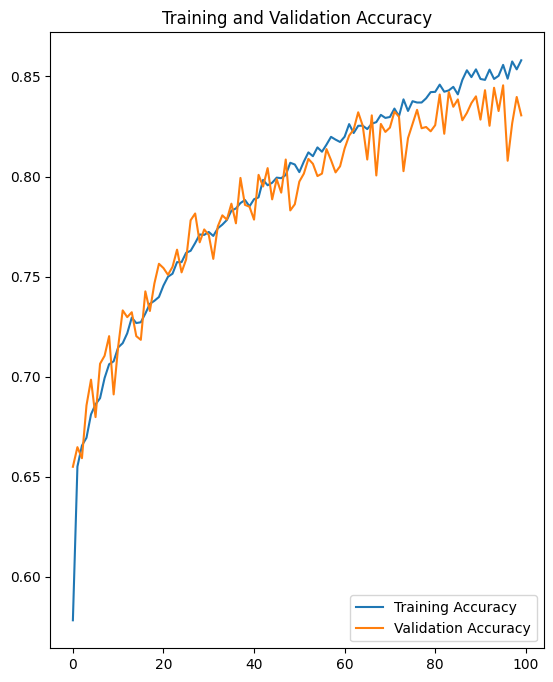

In [34]:
'''plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('trainging and validn accurancy')'''

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(100), acc[:100], label='Training Accuracy')
plt.plot(range(100), val_acc[:100], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


First Image to predict
Actual Label: BCC
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[5.0821543e-01 2.7309346e-03 3.2638845e-01 7.1022819e-06 9.4634995e-02
 6.8023160e-02]


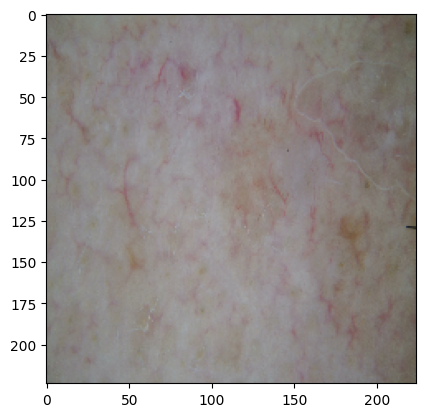

In [35]:
for images_batch, labels_batch in test_ds.take(1):
    first_img=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("First Image to predict")
    plt.imshow(first_img)
    print("Actual Label:", class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print(batch_prediction[0])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions= model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


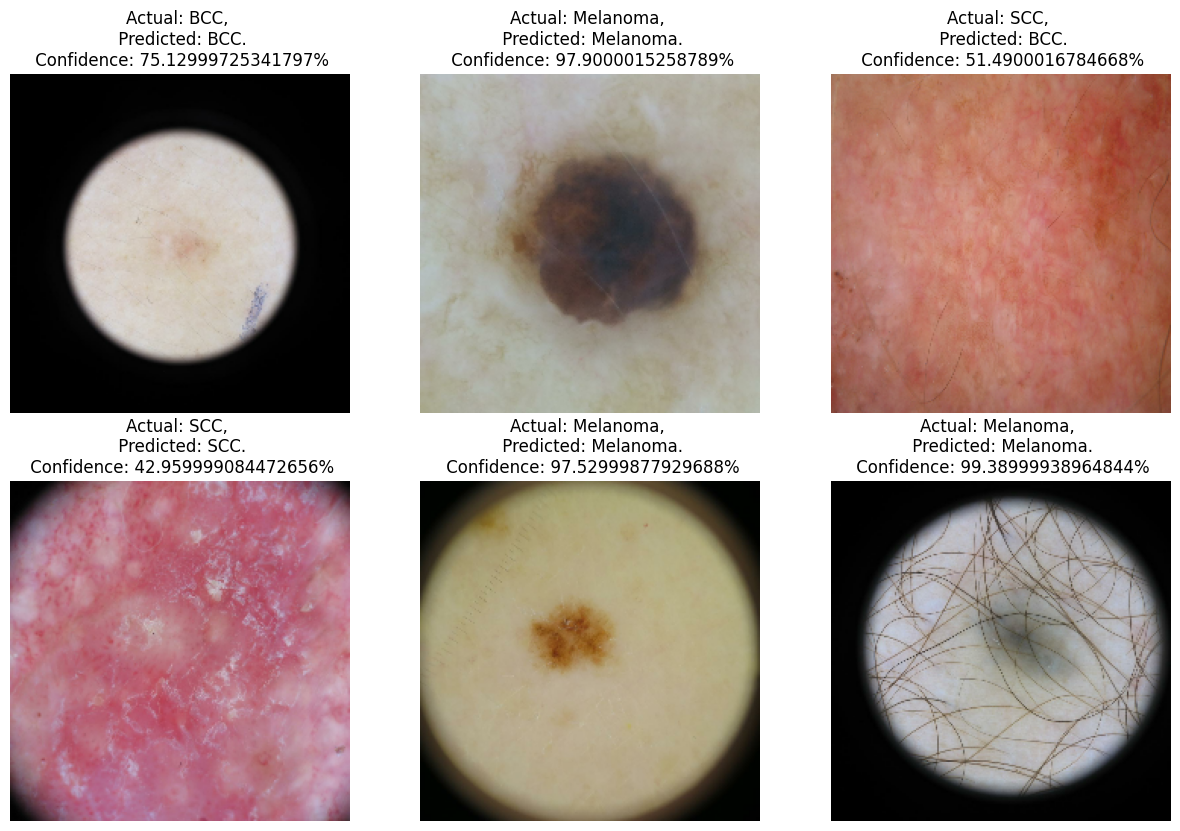

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax= plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class= class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [38]:
model_version=11
model.export(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/11\assets


INFO:tensorflow:Assets written to: ../saved_models/11\assets


Saved artifact at '../saved_models/11'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2944675048784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675048976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675049936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675049360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675052240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675053200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675052624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675052432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2944675053008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2945243857936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2945243858128: TensorSpec(shape=

In [39]:
model

<Sequential name=sequential_2, built=True>